# Calculations for several molecules with aug-cc-pVQZ (several basis sets)

In [5]:
from project_3_indicator import run_calculation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
methods = ['HF','CISD']
scanning_props = {'directions':'x,z','atom_indices':'1', 'end_distance':5}
basis_name='TZVP'


In [9]:
def plot_molecule_methods(results):
    """
    Enhanced plot for comparing different methods for various molecules
    with four subplots: two for different directions, and two for 3D visualizations.
    The molecule could be 'ethene', 'butadiene', or 'hexatriene'.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import cm
    from matplotlib.colors import LogNorm

    molecule = results[0]['molecule_name']
    # Set up the plot style with larger elements for presentation
    plt.rcParams.update({
        'font.size': 14,
        'axes.labelsize': 16,
        'axes.titlesize': 18,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'lines.linewidth': 3
    })

    # Define colors - ensuring they are correctly associated with methods
    colors = {
        'HF': '#077FAE',       # cerulean
        'CISD': '#C29044',     # goldenrod
        'CASSCF': '#786EAE',   # amethyst
        'default': '#333333'   # charcoal for any other method
    }

    # Define molecule-specific parameters
    molecule_params = {
        'ethene': {'cascf': (2, 2), 'methods': ['HF', 'CISD', 'CASSCF(2,2)']},
        'butadiene': {'cascf': (4, 4), 'methods': ['HF', 'CISD', 'CASSCF(4,4)']},
        'hexatriene': {'cascf': (6, 6), 'methods': ['HF', 'CISD', 'CASSCF(6,6)']}
    }

    # Set the method labels and colors
    if molecule not in molecule_params:
        raise ValueError(f"Molecule '{molecule}' not supported. Choose from 'ethene', 'butadiene', or 'hexatriene'.")

    params = molecule_params[molecule]
    cascf_label = f'CASSCF({params["cascf"][0]},{params["cascf"][1]})'

    # Create figure with four subplots (2x2 grid)
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])

    fig.patch.set_alpha(0.0)  # Transparent background
    for ax in [ax1, ax2, ax3, ax4]:
        ax.patch.set_alpha(0.0)  # Transparent plot background

    # Create secondary axes for logarithmic scales
    ax1_twin = ax1.twinx()
    ax1_twin.patch.set_alpha(0.0)
    ax2_twin = ax2.twinx()
    ax2_twin.patch.set_alpha(0.0)

    # Store handles for legend
    handles = []
    labels = []

    # Variables to store cube data for 3D plots (only for CASSCF methods)
    cube_data_xr = None
    cube_data_id = None
    method_for_3d = None

    min_x_value = float('inf')  # For adjusting second plot x-axis

    for result in results:
        df = result['ontop_data']
        method = result['method_name']

        # Store cube data for 3D plots (only using CASSCF data)
        if 'ontop_cube' in result and method.startswith('CASSCF'):
            cube_df = result['ontop_cube']
            if 'x' in cube_df.columns and 'y' in cube_df.columns and 'z' in cube_df.columns:
                # Calculate X(r) for the cube data
                cube_df['X(r)'] = 2 * cube_df['ontop'] / (cube_df['density']**2)
                cube_data_xr = cube_df
                if 'indicator_dynamic' in cube_df.columns:
                    cube_data_id = cube_df
                method_for_3d = method

        # Determine the color to use for this method
        if method == 'HF':
            color = colors['HF']
        elif method == 'CISD':
            color = colors['CISD']
        elif method.startswith('CASSCF'):
            color = colors['CASSCF']
        else:
            color = colors['default']

        # Calculate indicators for line plots
        df['X(r)'] = 2 * df['ontop'] / (df['density']**2)

        # Plot perpendicular direction (x)
        x_data = df[df['direction'] == 'x']
        mask_x = x_data['r'] <= 1.2

        line1, = ax1.plot(x_data.loc[mask_x, 'r'], x_data.loc[mask_x, 'X(r)'],
                 color=color, linewidth=3,
                 label=f'X(r) - {method}')

        # Only plot I_D for non-CASSCF methods
        if 'indicator_dynamic' in x_data.columns and not method.startswith('CASSCF'):
            line2, = ax1_twin.plot(x_data.loc[mask_x, 'r'], x_data.loc[mask_x, 'indicator_dynamic'],
                         color=color, linewidth=2, linestyle='--', alpha=0.8,
                         label=f'$I_D$ - {method}')

            # Add to handles and labels if this is CISD
            if method == 'CISD':
                handles.append(line2)
                labels.append(f'$I_D$ - {method}')

        # Plot bond direction (z)
        z_data = df[df['direction'] == 'z'].copy()  # Create an explicit copy to avoid the SettingWithCopyWarning

        # Initialize min_r_at_min_x to avoid referencing before assignment
        min_r_at_min_x = 0

        # Adjust CASSCF to the respective molecule
        if method.startswith('CASSCF'):
            min_index = z_data['X(r)'].idxmin()
            min_r_at_min_x = z_data.loc[min_index, 'r']  # Assign the minimum value to min_r_at_min_x

        # Use .loc to modify the dataframe to avoid the SettingWithCopyWarning
        z_data.loc[:, 'r'] = z_data['r'] - min_r_at_min_x

        ax2.plot(z_data['r'], z_data['X(r)'],
                color=color, linewidth=3,
                label=f'X(r) - {method}')

        # Only plot I_D for non-CASSCF methods
        if 'indicator_dynamic' in z_data.columns and not method.startswith('CASSCF'):
            ax2_twin.plot(z_data['r'], z_data['indicator_dynamic'],
                        color=color, linewidth=2, linestyle='--', alpha=0.8,
                        label=f'$I_D$ - {method}')

        # Add to legend
        handles.append(line1)
        labels.append(f'X(r) - {method}')

    # Add reference line at y = 1 for line plots
    ax1.axhline(y=1, color=colors['default'], linewidth=1, linestyle='-', alpha=0.5)
    ax2.axhline(y=1, color=colors['default'], linewidth=1, linestyle='-', alpha=0.5)

    # Customize first subplot (perpendicular)
    ax1.set_xlabel('r (Å)', color=colors['default'], fontweight='bold')
    ax1.set_ylabel('X(r)', color=colors['default'], fontweight='bold', rotation=0, loc='top')
    ax1.set_title(f'{molecule.capitalize()} - Perpendicular to the plane',
               fontsize=18, color=colors['default'], fontweight='bold', pad=10)

    # Enforce the limit for the perpendicular plot
    ax1.set_xlim(0, 1.2)

    ax1.grid(True, linestyle='--', alpha=0.3, color=colors['default'])
    ax1.tick_params(colors=colors['default'], width=2, length=6)

    # Set logarithmic scale for secondary axis and invert it
    ax1_twin.set_ylabel('$I_D$', color=colors['default'], fontweight='bold', rotation=0, loc='top')
    ax1_twin.set_yscale('log')
    ax1_twin.invert_yaxis()  # Invert the axis
    ax1_twin.tick_params(colors=colors['default'], width=2, length=6)

    # Customize second subplot (bond direction)
    ax2.set_xlabel('r (Å)', color=colors['default'], fontweight='bold')
    ax2.set_ylabel('X(r)', color=colors['default'], fontweight='bold', rotation=0, loc='top')
    ax2.set_title(f'{molecule.capitalize()} - C-C bond direction',
               fontsize=18, color=colors['default'], fontweight='bold', pad=10)

    ax2.grid(True, linestyle='--', alpha=0.3, color=colors['default'])
    ax2.tick_params(colors=colors['default'], width=2, length=6)
    ax2.set_xlim(-5, 5)
    ax2.set_ylim(0, 1.2)

    # Set logarithmic scale for secondary axis and invert it
    ax2_twin.set_ylabel('$I_D$', color=colors['default'], fontweight='bold', rotation=0, loc='top')
    ax2_twin.set_yscale('log')
    ax2_twin.invert_yaxis()  # Invert the axis
    ax2_twin.tick_params(colors=colors['default'], width=2, length=6)

    # Make axis lines more visible for line plots
    for ax in [ax1, ax2, ax1_twin, ax2_twin]:
        for spine in ax.spines.values():
            spine.set_linewidth(2)
        ax.minorticks_on()
        ax.tick_params(which='minor', length=3, width=1.5)

    # Plot 3D visualization (2D colormap) for X(r) and I_D if data is available
    if cube_data_xr is not None:
        # Find unique y and z values, and create 2D grid
        unique_y = np.sort(cube_data_xr['y'].unique())
        unique_z = np.sort(cube_data_xr['z'].unique())

        # Select a specific x plane (e.g., x=0 or closest to 0)
        target_x = 0
        closest_x = cube_data_xr['x'].iloc[(cube_data_xr['x'] - target_x).abs().argsort()[0]]
        x_plane_data = cube_data_xr[cube_data_xr['x'] == closest_x]

        # Create meshgrid
        Y, Z = np.meshgrid(unique_y, unique_z)
        X_r_values = np.zeros_like(Y)

        # Fill the X(r) values
        for i, y_val in enumerate(unique_y):
            for j, z_val in enumerate(unique_z):
                filtered = x_plane_data[(x_plane_data['y'] == y_val) & (x_plane_data['z'] == z_val)]
                if not filtered.empty:
                    X_r_values[j, i] = filtered['X(r)'].values[0]

        # Plot X(r) heatmap
        im3 = ax3.pcolormesh(Y, Z, X_r_values, cmap='viridis', vmin=0, vmax=1.5, shading='auto')
        fig.colorbar(im3, ax=ax3, label='X(r)')
        ax3.set_xlabel('y (Å)', color=colors['default'], fontweight='bold')
        ax3.set_ylabel('z (Å)', color=colors['default'], fontweight='bold')
        ax3.set_title(f'{molecule.capitalize()} - X(r) YZ Plane (x ≈ {closest_x:.2f} Å) - {method_for_3d}',
                    fontsize=18, color=colors['default'], fontweight='bold', pad=10)
        ax3.grid(True, linestyle='--', alpha=0.3, color=colors['default'])
        ax3.set_aspect('equal')

        # Plot I_D heatmap if available
        if cube_data_id is not None and 'indicator_dynamic' in cube_data_id.columns:
            x_plane_data_id = cube_data_id[cube_data_id['x'] == closest_x]
            I_D_values = np.zeros_like(Y)

            # Fill the I_D values
            for i, y_val in enumerate(unique_y):
                for j, z_val in enumerate(unique_z):
                    filtered = x_plane_data_id[(x_plane_data_id['y'] == y_val) & (x_plane_data_id['z'] == z_val)]
                    if not filtered.empty:
                        I_D_values[j, i] = filtered['indicator_dynamic'].values[0]

            # Use LogNorm for I_D values
            min_id = np.nanmin(I_D_values[I_D_values > 0])  # Avoid zeros for log scale
            max_id = np.nanmax(I_D_values)
            norm = LogNorm(vmin=min_id, vmax=max_id)

            im4 = ax4.pcolormesh(Y, Z, I_D_values, cmap='plasma', norm=norm, shading='auto')
            cbar = fig.colorbar(im4, ax=ax4, label='$I_D$ (log scale)')
            cbar.ax.invert_yaxis()  # Invert colorbar to match the line plots
            ax4.set_xlabel('y (Å)', color=colors['default'], fontweight='bold')
            ax4.set_ylabel('z (Å)', color=colors['default'], fontweight='bold')
            ax4.set_title(f'{molecule.capitalize()} - $I_D$ YZ Plane (x ≈ {closest_x:.2f} Å) - {method_for_3d}',
                        fontsize=18, color=colors['default'], fontweight='bold', pad=10)
            ax4.grid(True, linestyle='--', alpha=0.3, color=colors['default'])
            ax4.set_aspect('equal')
    else:
        # No CASSCF cube data available
        ax3.text(0.5, 0.5, 'No CASSCF 3D data available for X(r)',
                 ha='center', va='center', fontsize=16, color=colors['default'])
        ax4.text(0.5, 0.5, 'No CASSCF 3D data available for $I_D',
                 ha='center', va='center', fontsize=16, color=colors['default'])

    # Main title
    fig.suptitle(f'{molecule.capitalize()} TZVP',
               fontsize=22, color=colors['default'], fontweight='bold')

    # Add single legend at the bottom
    fig.legend(handles, labels,
              loc='lower center', bbox_to_anchor=(0.5, 0.02),
              ncol=4, frameon=True, facecolor='white',
              edgecolor=colors['default'], fontsize=12)

    plt.tight_layout()
    # Adjust layout to make room for the legend
    plt.subplots_adjust(bottom=0.12)

    return fig


## Ground state

In [ ]:
results = run_calculation(
    molecule_name="ethene",
    method_name=methods + ['CASSCF(2,2)'],
    basis_name=basis_name,
    scanning_props=scanning_props
)

fig = plot_molecule_methods(results)


Connected to atlas.


Connected to atlas.


INFO:project_3_indicator.input.specification:Creating input specification for ethene_HF_TZVP
INFO:project_3_indicator.input.specification:Using default basis set 'TZVP'.
INFO:root:Running GaussianCalculation for CALC_000001


Geometry for ethene successfully loaded.
Method name: HF True


INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4)
INFO:root:Command output: drwx------ 1 javidom qchem 66 Mar 12 16:39 /dipc/javidom/proyect-3-indicator/CALC_000001

INFO:paramiko.transport:Authentication (publickey) successful!


Connected to atlas.


INFO:project_3_indicator.input.specification:Creating input specification for ethene_CISD_TZVP
INFO:project_3_indicator.input.specification:Using default basis set 'TZVP'.
INFO:root:Running GaussianCalculation for CALC_000002


Geometry for ethene successfully loaded.
Method name: CISD False


INFO:root:Command output: 
INFO:root:Created directory: /scratch/javidom/proyect-3-indicator/CALC_000001
INFO:root:Created fresh scratch directory: /scratch/javidom/proyect-3-indicator/CALC_000001


Gaussian input file './test/CALC_000001.com' generated successfully.


INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4)
INFO:paramiko.transport:Authentication (publickey) successful!


Connected to atlas.


INFO:project_3_indicator.input.specification:Creating input specification for ethene_CASSCF(2,2)_TZVP
INFO:project_3_indicator.input.specification:Using default basis set 'TZVP'.
INFO:root:Generated Gaussian SLURM script at slurm_scripts/CALC_000001_gaussian.slurm
INFO:root:Running GaussianCalculation for CALC_000003


Geometry for ethene successfully loaded.
Method name: CASSCF(2,2) False
Uploaded test/CALC_000001.com to /dipc/javidom/proyect-3-indicator/CALC_000001/CALC_000001.com on the cluster.


INFO:root:Command output: drwx------ 1 javidom qchem 62 Mar 12 16:46 /dipc/javidom/proyect-3-indicator/CALC_000002

INFO:root:Input files prepared for CALC_000001


Uploaded slurm_scripts/CALC_000001_gaussian.slurm to /dipc/javidom/proyect-3-indicator/CALC_000001/CALC_000001_gaussian.slurm on the cluster.


INFO:root:Command output: 
INFO:root:Created directory: /scratch/javidom/proyect-3-indicator/CALC_000002
INFO:root:Created fresh scratch directory: /scratch/javidom/proyect-3-indicator/CALC_000002


Gaussian input file './test/CALC_000002.com' generated successfully.


INFO:root:Command output: drwx------ 1 javidom qchem 62 Mar 12 16:40 /dipc/javidom/proyect-3-indicator/CALC_000003

INFO:root:Command output: 
INFO:root:Generated Gaussian SLURM script at slurm_scripts/CALC_000002_gaussian.slurm


Uploaded test/CALC_000002.com to /dipc/javidom/proyect-3-indicator/CALC_000002/CALC_000002.com on the cluster.


INFO:root:Command output: 
INFO:root:Created directory: /scratch/javidom/proyect-3-indicator/CALC_000003
INFO:root:Created fresh scratch directory: /scratch/javidom/proyect-3-indicator/CALC_000003


Gaussian input file './test/CALC_000003.com' generated successfully.


INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000001/CALC_000001.com

INFO:root:Moved CALC_000001.com from colony to scratch for CALC_000001
INFO:root:Input files prepared for CALC_000002


Uploaded slurm_scripts/CALC_000002_gaussian.slurm to /dipc/javidom/proyect-3-indicator/CALC_000002/CALC_000002_gaussian.slurm on the cluster.


INFO:root:Generated Gaussian SLURM script at slurm_scripts/CALC_000003_gaussian.slurm


Uploaded test/CALC_000003.com to /dipc/javidom/proyect-3-indicator/CALC_000003/CALC_000003.com on the cluster.


INFO:root:Command output: 
INFO:root:Command output: 
INFO:root:Input files prepared for CALC_000003


Uploaded slurm_scripts/CALC_000003_gaussian.slurm to /dipc/javidom/proyect-3-indicator/CALC_000003/CALC_000003_gaussian.slurm on the cluster.


INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000001/CALC_000001_gaussian.slurm

INFO:root:Moved CALC_000001_gaussian.slurm from colony to scratch for CALC_000001
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000002/CALC_000002.com

INFO:root:Moved CALC_000002.com from colony to scratch for CALC_000002
INFO:root:Command output: 
INFO:root:Command output: 
INFO:root:Command output: Submitted batch job 2428940

INFO:root:Submitted job with ID 2428940 for CALC_000001_gaussian
INFO:root:Submitted job 2428940 for CALC_000001_gaussian
INFO:root:Monitoring job 2428940 for CALC_000001_gaussian...
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000003/CALC_000003.com

INFO:root:Moved CALC_000003.com from colony to scratch for CALC_000003
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000002/CALC_000002_gaussian.slurm

INFO:root:Moved CALC_000002_gaussian.slurm from colony to scratch for CALC_000002
INFO:root:Co

INCA input file './test/CALC_000001.inp' generated successfully.


INFO:root:Generated INCA SLURM script at slurm_scripts/CALC_000001_inca.slurm


Uploaded test/CALC_000001.inp to /dipc/javidom/proyect-3-indicator/CALC_000001/CALC_000001.inp on the cluster.
Uploaded slurm_scripts/CALC_000001_inca.slurm to /dipc/javidom/proyect-3-indicator/CALC_000001/CALC_000001_inca.slurm on the cluster.


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000001/CALC_000001.wfx

INFO:root:Input files prepared for INCA calculation of CALC_000001
INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000001/CALC_000001.dm2p

INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000001/CALC_000001_inca.slurm

INFO:root:Moved CALC_000001_inca.slurm from colony to scratch for CALC_000001
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000001/CALC_000001.inp

INFO:root:Moved CALC_000001.inp from colony to scratch for CALC_000001
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000001/CALC_000001.wfx

INFO:root:Moved CALC_000001.wfx from colony to scratch for CALC_000001
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000001/CALC_000001.dm2p

INFO:root:Moved CALC_000001.dm2p from colony to sc

here


INFO:root:Command output: 
INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000003/CALC_000003.log

INFO:root:Generated DMN SLURM script at slurm_scripts/CALC_000003_dmn.slurm


Uploaded slurm_scripts/CALC_000003_dmn.slurm to /dipc/javidom/proyect-3-indicator/CALC_000003/CALC_000003_dmn.slurm on the cluster.


INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000003/CALC_000003_dmn.slurm

INFO:root:Moved CALC_000003_dmn.slurm from colony to scratch for CALC_000003
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000003/CALC_000003.log

INFO:root:Moved CALC_000003.log from colony to scratch for CALC_000003
INFO:root:Command output: Submitted batch job 2428945

INFO:root:Submitted job with ID 2428945 for CALC_000003_dmn
INFO:root:Submitted job 2428945 for CALC_000003_dmn
INFO:root:Monitoring job 2428945 for CALC_000003_dmn...
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2428945     general     regular       CALC_000003_dmn       javidom     R         0:01      1  atlas-301

INFO:root:Job 2428945 for CALC_000003_dmn still running, checking again in 1 seconds
INFO:root:Command output:     

Downloaded /dipc/javidom/proyect-3-indicator/CALC_000001/CALC_000001.log to /home/javi/Desktop/Doctorado/proyect-3-indicator/results/CALC_000001/CALC_000001.log locally.


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000001/ontop.dat

INFO:root:Found ontop.dat on cluster, downloading...


Downloaded /dipc/javidom/proyect-3-indicator/CALC_000001/ontop.dat to /home/javi/Desktop/Doctorado/proyect-3-indicator/results/CALC_000001/ontop.dat locally.


INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)

INFO:root:Job 2428945 for CALC_000003_dmn completed after 0:00:09.998334
INFO:root:Job 2428945 completed successfully
INFO:root:Job 2428945 completed successfully for CALC_000003
ERROR:root:Error executing command: ls: cannot access /dipc/javidom/proyect-3-indicator/CALC_000001/ontop.cube: No such file or directory

INFO:root:Command output: 
INFO:root:Running DMNCalculation for CALC_000002
ERROR:root:Error executing command: ls: cannot access /dipc/javidom/proyect-3-indicator/CALC_000001/density.cube: No such file or directory

INFO:root:Command output: drwx------ 1 javidom qchem 65 Mar 12 17:01 /dipc/javidom/proyect-3-indicator/CALC_000002

ERROR:root:Error executing command: ls: cannot access /dipc/javidom/proyect-3-indicator/CALC_000001/ID.cube: No such file or directory

ERROR:root:Error processing results for CALC_000001: local va

Disconnected from cluster.


INFO:root:Command output: 
INFO:root:Created directory: /scratch/javidom/proyect-3-indicator/CALC_000002
INFO:root:Created fresh scratch directory: /scratch/javidom/proyect-3-indicator/CALC_000002
INFO:root:Command output: 
INFO:root:Running DM2PRIMCalculation for CALC_000003
INFO:root:Command output: drwx------ 1 javidom qchem 63 Mar 12 17:00 /dipc/javidom/proyect-3-indicator/CALC_000003

INFO:root:Command output: 
INFO:root:Created directory: /scratch/javidom/proyect-3-indicator/CALC_000003
INFO:root:Created fresh scratch directory: /scratch/javidom/proyect-3-indicator/CALC_000003
INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000003/Test.FChk

INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000002/CALC_000002.log

INFO:root:Command output: 
INFO:root:Renamed Test.FChk to CALC_000003.fchk
INFO:root:Command output: 
INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000003/CALC_000003.dm2



here


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000003/CALC_000003.fchk

INFO:root:Generated DM2PRIM SLURM script at slurm_scripts/CALC_000003_dm2prim.slurm
INFO:root:Command output: 
INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000002/CALC_000002.log

INFO:root:Generated DMN SLURM script at slurm_scripts/CALC_000002_dmn.slurm


Uploaded slurm_scripts/CALC_000003_dm2prim.slurm to /dipc/javidom/proyect-3-indicator/CALC_000003/CALC_000003_dm2prim.slurm on the cluster.


INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000003/CALC_000003_dm2prim.slurm

INFO:root:Moved CALC_000003_dm2prim.slurm from colony to scratch for CALC_000003


Uploaded slurm_scripts/CALC_000002_dmn.slurm to /dipc/javidom/proyect-3-indicator/CALC_000002/CALC_000002_dmn.slurm on the cluster.


INFO:root:Command output: 
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000003/CALC_000003.dm2

INFO:root:Moved CALC_000003.dm2 from colony to scratch for CALC_000003
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000002/CALC_000002_dmn.slurm

INFO:root:Moved CALC_000002_dmn.slurm from colony to scratch for CALC_000002
INFO:root:Command output: 
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000003/CALC_000003.fchk

INFO:root:Moved CALC_000003.fchk from colony to scratch for CALC_000003
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000002/CALC_000002.log

INFO:root:Moved CALC_000002.log from colony to scratch for CALC_000002
INFO:root:Command output: Submitted batch job 2428946

INFO:root:Submitted job with ID 2428946 for CALC_000003_dm2prim
INFO:root:Submitted job 2428946 for CALC_000003_dm2prim
INFO:root:Monitoring job 2428946 for CALC_000003_dm

INCA input file './test/CALC_000003.inp' generated successfully.


INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2428947     general     regular       CALC_000002_dmn       javidom     R         0:13      1  atlas-301

INFO:root:Job 2428947 for CALC_000002_dmn still running, checking again in 8 seconds
INFO:root:Generated INCA SLURM script at slurm_scripts/CALC_000003_inca.slurm


Uploaded test/CALC_000003.inp to /dipc/javidom/proyect-3-indicator/CALC_000003/CALC_000003.inp on the cluster.
Uploaded slurm_scripts/CALC_000003_inca.slurm to /dipc/javidom/proyect-3-indicator/CALC_000003/CALC_000003_inca.slurm on the cluster.


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000003/CALC_000003.wfx

INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000003/CALC_000003.dm2p

INFO:root:Input files prepared for INCA calculation of CALC_000003
INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000003/CALC_000003.dm2p

INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000003/CALC_000003_inca.slurm

INFO:root:Moved CALC_000003_inca.slurm from colony to scratch for CALC_000003
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000003/CALC_000003.inp

INFO:root:Moved CALC_000003.inp from colony to scratch for CALC_000003
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000003/CALC_000003.wfx

INFO:root:Moved CALC_000003.wfx from colony to scratch for CALC_000003
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-

Downloaded /dipc/javidom/proyect-3-indicator/CALC_000003/CALC_000003.log to /home/javi/Desktop/Doctorado/proyect-3-indicator/results/CALC_000003/CALC_000003.log locally.


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000003/ontop.dat

INFO:root:Found ontop.dat on cluster, downloading...


Downloaded /dipc/javidom/proyect-3-indicator/CALC_000003/ontop.dat to /home/javi/Desktop/Doctorado/proyect-3-indicator/results/CALC_000003/ontop.dat locally.


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000003/ontop.cube

INFO:root:Found ontop.cube on cluster, downloading...


Downloaded /dipc/javidom/proyect-3-indicator/CALC_000003/ontop.cube to /home/javi/Desktop/Doctorado/proyect-3-indicator/results/CALC_000003/ontop.cube locally.


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000003/density.cube

INFO:root:Found density.cube on cluster, downloading...


Downloaded /dipc/javidom/proyect-3-indicator/CALC_000003/density.cube to /home/javi/Desktop/Doctorado/proyect-3-indicator/results/CALC_000003/density.cube locally.


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000003/ID.cube

INFO:root:Found ID.cube on cluster, downloading...
ERROR:root:Error processing results for CALC_000003: local variable 'Path' referenced before assignment
ERROR:root:Error in calculation workflow: local variable 'Path' referenced before assignment


Downloaded /dipc/javidom/proyect-3-indicator/CALC_000003/ID.cube to /home/javi/Desktop/Doctorado/proyect-3-indicator/results/CALC_000003/ID.cube locally.


Disconnected from cluster.


INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2428947     general     regular       CALC_000002_dmn       javidom     R         1:13      1  atlas-301

INFO:root:Job 2428947 for CALC_000002_dmn still running, checking again in 60 seconds
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2428947     general     regular       CALC_000002_dmn       javidom     R         2:16      1  atlas-301

INFO:root:Job 2428947 for CALC_000002_dmn still running, checking again in 60 seconds
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2428947     general     regular       CALC_000002_dmn       javidom     R         3:16      1  atlas-301

INFO:root:Job 2428

Uploaded slurm_scripts/CALC_000002_dm2prim.slurm to /dipc/javidom/proyect-3-indicator/CALC_000002/CALC_000002_dm2prim.slurm on the cluster.


INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000002/CALC_000002_dm2prim.slurm

INFO:root:Moved CALC_000002_dm2prim.slurm from colony to scratch for CALC_000002
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000002/CALC_000002.dm2

INFO:root:Moved CALC_000002.dm2 from colony to scratch for CALC_000002
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000002/CALC_000002.fchk

INFO:root:Moved CALC_000002.fchk from colony to scratch for CALC_000002
INFO:root:Command output: Submitted batch job 2428949

INFO:root:Submitted job with ID 2428949 for CALC_000002_dm2prim
INFO:root:Submitted job 2428949 for CALC_000002_dm2prim
INFO:root:Monitoring job 2428949 for CALC_000002_dm2prim...
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2428949  

In [21]:
results[1]

{'calculation_id': 'CALC_000005',
 'molecule_name': 'ethene',
 'method_name': 'CISD',
 'basis_name': 'TZVP',
 'energy': None,
 'calculation_time': None,
 'geometry': '',
 'ontop_data':      atom direction     r         ontop       density  indicator_dynamic  \
 0       1         x -5.00  1.607559e-17  5.808379e-09       2.571245e-10   
 1       1         x -4.95  3.045035e-17  7.994064e-09       3.538801e-10   
 2       1         x -4.90  5.730987e-17  1.096696e-08       4.854836e-10   
 3       1         x -4.85  1.071713e-16  1.499721e-08       6.638942e-10   
 4       1         x -4.80  1.991310e-16  2.044282e-08       9.049592e-10   
 ..    ...       ...   ...           ...           ...                ...   
 397     1         z  4.80  1.991310e-16  2.044282e-08       9.049592e-10   
 398     1         z  4.85  1.071713e-16  1.499721e-08       6.638942e-10   
 399     1         z  4.90  5.730987e-17  1.096696e-08       4.854836e-10   
 400     1         z  4.95  3.045035e-17  7.99

In [ ]:
results = run_calculation(
    molecule_name="butadiene",
    method_name=methods + ['CASSCF(4,4)'],
    basis_name=basis_name,
    scanning_props=scanning_props
)

fig = plot_indicators_comparison(results)



INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4)
INFO:paramiko.transport:Authentication (publickey) successful!


Connected to atlas.


INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4)
INFO:paramiko.transport:Authentication (publickey) successful!


Connected to atlas.


INFO:project_3_indicator.input.specification:Creating input specification for butadiene_HF_TZVP
INFO:project_3_indicator.input.specification:Dependencies validated successfully.
INFO:project_3_indicator.input.specification:Using default basis set 'TZVP'.
INFO:root:Running GaussianCalculation for CALC_000127


Geometry for butadiene successfully loaded.
Method name: HF True


ERROR:root:Error executing command: ls: cannot access /dipc/javidom/proyect-3-indicator/CALC_000127: No such file or directory

INFO:root:Command output: 
INFO:root:Created directory: /dipc/javidom/proyect-3-indicator/CALC_000127
INFO:root:Created new colony directory: /dipc/javidom/proyect-3-indicator/CALC_000127
INFO:root:Command output: 
INFO:root:Created directory: /scratch/javidom/proyect-3-indicator/CALC_000127
INFO:root:Created fresh scratch directory: /scratch/javidom/proyect-3-indicator/CALC_000127


Gaussian input file './test/CALC_000127.com' generated successfully.


INFO:root:Generated Gaussian SLURM script at slurm_scripts/CALC_000127_gaussian.slurm


Uploaded test/CALC_000127.com to /dipc/javidom/proyect-3-indicator/CALC_000127/CALC_000127.com on the cluster.


INFO:root:Input files prepared for CALC_000127
INFO:root:Command output: 


Uploaded slurm_scripts/CALC_000127_gaussian.slurm to /dipc/javidom/proyect-3-indicator/CALC_000127/CALC_000127_gaussian.slurm on the cluster.


INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000127/CALC_000127.com

INFO:root:Moved CALC_000127.com from colony to scratch for CALC_000127
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000127/CALC_000127_gaussian.slurm

INFO:root:Moved CALC_000127_gaussian.slurm from colony to scratch for CALC_000127
INFO:root:Command output: Submitted batch job 2372930

INFO:root:Submitted job with ID 2372930 for CALC_000127_gaussian
INFO:root:Submitted job 2372930 for CALC_000127_gaussian
INFO:root:Monitoring job 2372930 for CALC_000127_gaussian...
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2372930     general     regular  CALC_000127_gaussian       javidom     R         0:01      1  atlas-302

INFO:root:Job 2372930 for CALC_000127_gaussian still running, checking again in 1 seconds
INFO:paramiko.transport:Con

Connected to atlas.


INFO:project_3_indicator.input.specification:Creating input specification for butadiene_CISD_TZVP
INFO:project_3_indicator.input.specification:Dependencies validated successfully.
INFO:project_3_indicator.input.specification:Using default basis set 'TZVP'.
INFO:root:Running GaussianCalculation for CALC_000128


Geometry for butadiene successfully loaded.
Method name: CISD False


ERROR:root:Error executing command: ls: cannot access /dipc/javidom/proyect-3-indicator/CALC_000128: No such file or directory

INFO:root:Command output: 
INFO:root:Created directory: /dipc/javidom/proyect-3-indicator/CALC_000128
INFO:root:Created new colony directory: /dipc/javidom/proyect-3-indicator/CALC_000128
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2372930     general     regular  CALC_000127_gaussian       javidom     R         0:03      1  atlas-302

INFO:root:Job 2372930 for CALC_000127_gaussian still running, checking again in 2 seconds
INFO:root:Command output: 
INFO:root:Created directory: /scratch/javidom/proyect-3-indicator/CALC_000128
INFO:root:Created fresh scratch directory: /scratch/javidom/proyect-3-indicator/CALC_000128


Gaussian input file './test/CALC_000128.com' generated successfully.


INFO:root:Generated Gaussian SLURM script at slurm_scripts/CALC_000128_gaussian.slurm


Uploaded test/CALC_000128.com to /dipc/javidom/proyect-3-indicator/CALC_000128/CALC_000128.com on the cluster.


INFO:root:Input files prepared for CALC_000128


Uploaded slurm_scripts/CALC_000128_gaussian.slurm to /dipc/javidom/proyect-3-indicator/CALC_000128/CALC_000128_gaussian.slurm on the cluster.


INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000128/CALC_000128.com

INFO:root:Moved CALC_000128.com from colony to scratch for CALC_000128
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000128/CALC_000128_gaussian.slurm

INFO:root:Moved CALC_000128_gaussian.slurm from colony to scratch for CALC_000128
INFO:root:Command output: Submitted batch job 2372931

INFO:root:Submitted job with ID 2372931 for CALC_000128_gaussian
INFO:root:Submitted job 2372931 for CALC_000128_gaussian
INFO:root:Monitoring job 2372931 for CALC_000128_gaussian...
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2372930     general     regular  CALC_000127_gaussian       javidom    CG         0:05      1  atlas-302

INFO:root:Job 2372930 for CALC_000127_gaussian still running, checking again in 4 seconds


Connected to atlas.


INFO:project_3_indicator.input.specification:Creating input specification for butadiene_CASSCF(4,4)_TZVP
INFO:project_3_indicator.input.specification:Dependencies validated successfully.
INFO:project_3_indicator.input.specification:Using default basis set 'TZVP'.
INFO:root:Running GaussianCalculation for CALC_000129


Geometry for butadiene successfully loaded.
Method name: CASSCF(4,4) False


ERROR:root:Error executing command: ls: cannot access /dipc/javidom/proyect-3-indicator/CALC_000129: No such file or directory

INFO:root:Command output: 
INFO:root:Created directory: /dipc/javidom/proyect-3-indicator/CALC_000129
INFO:root:Created new colony directory: /dipc/javidom/proyect-3-indicator/CALC_000129
INFO:root:Command output: 
INFO:root:Created directory: /scratch/javidom/proyect-3-indicator/CALC_000129
INFO:root:Created fresh scratch directory: /scratch/javidom/proyect-3-indicator/CALC_000129


Gaussian input file './test/CALC_000129.com' generated successfully.


INFO:root:Generated Gaussian SLURM script at slurm_scripts/CALC_000129_gaussian.slurm
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2372931     general     regular  CALC_000128_gaussian       javidom     R         0:02      1  atlas-302

INFO:root:Job 2372931 for CALC_000128_gaussian still running, checking again in 2 seconds


Uploaded test/CALC_000129.com to /dipc/javidom/proyect-3-indicator/CALC_000129/CALC_000129.com on the cluster.


INFO:root:Input files prepared for CALC_000129
INFO:root:Command output: 


Uploaded slurm_scripts/CALC_000129_gaussian.slurm to /dipc/javidom/proyect-3-indicator/CALC_000129/CALC_000129_gaussian.slurm on the cluster.


INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000129/CALC_000129.com

INFO:root:Moved CALC_000129.com from colony to scratch for CALC_000129
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000129/CALC_000129_gaussian.slurm

INFO:root:Moved CALC_000129_gaussian.slurm from colony to scratch for CALC_000129
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)

INFO:root:Job 2372930 for CALC_000127_gaussian completed after 0:00:10.981949
INFO:root:Job 2372930 completed successfully
INFO:root:Job 2372930 completed successfully for CALC_000127
INFO:root:Command output: Submitted batch job 2372932

INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2372931     general     regular  CALC_000128_gaussian       javidom   

INCA input file './test/CALC_000127.inp' generated successfully.
Uploaded test/CALC_000127.inp to /dipc/javidom/proyect-3-indicator/CALC_000127/CALC_000127.inp on the cluster.


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000127/CALC_000127.wfx

INFO:root:Input files prepared for INCA calculation of CALC_000127


Uploaded slurm_scripts/CALC_000127_inca.slurm to /dipc/javidom/proyect-3-indicator/CALC_000127/CALC_000127_inca.slurm on the cluster.


ERROR:root:Error executing command: ls: cannot access /dipc/javidom/proyect-3-indicator/CALC_000127/CALC_000127.dm2p: No such file or directory

INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000127/CALC_000127_inca.slurm

INFO:root:Moved CALC_000127_inca.slurm from colony to scratch for CALC_000127
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000127/CALC_000127.inp

INFO:root:Moved CALC_000127.inp from colony to scratch for CALC_000127
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000127/CALC_000127.wfx

INFO:root:Moved CALC_000127.wfx from colony to scratch for CALC_000127
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2372932     general     regular  CALC_000129_gaussian       javidom     R         0:00      1  atlas-302

I

here


INFO:root:Command output: 
INFO:root:Command output: drwx------ 1 javidom qchem 8 Feb 20 20:29 /dipc/javidom/proyect-3-indicator/CALC_000129

INFO:root:Command output: 
INFO:root:Created directory: /scratch/javidom/proyect-3-indicator/CALC_000129
INFO:root:Created fresh scratch directory: /scratch/javidom/proyect-3-indicator/CALC_000129
INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000128/CALC_000128.log

INFO:root:Generated DMN SLURM script at slurm_scripts/CALC_000128_dmn.slurm
INFO:root:Command output: 


Uploaded slurm_scripts/CALC_000128_dmn.slurm to /dipc/javidom/proyect-3-indicator/CALC_000128/CALC_000128_dmn.slurm on the cluster.


INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000128/CALC_000128_dmn.slurm

INFO:root:Moved CALC_000128_dmn.slurm from colony to scratch for CALC_000128
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000128/CALC_000128.log

INFO:root:Moved CALC_000128.log from colony to scratch for CALC_000128
INFO:root:Command output: Submitted batch job 2372944

INFO:root:Submitted job with ID 2372944 for CALC_000128_dmn
INFO:root:Submitted job 2372944 for CALC_000128_dmn
INFO:root:Monitoring job 2372944 for CALC_000128_dmn...
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2372933     general     regular      CALC_000127_inca       javidom     R         1:09      1  atlas-302

INFO:root:Job 2372933 for CALC_000127_inca still running, checking again in 60 seconds
INFO:root:Command output:                JOBID   PARTIT

here


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000129/CALC_000129.log

INFO:root:Generated DMN SLURM script at slurm_scripts/CALC_000129_dmn.slurm
INFO:root:Command output: 


Uploaded slurm_scripts/CALC_000129_dmn.slurm to /dipc/javidom/proyect-3-indicator/CALC_000129/CALC_000129_dmn.slurm on the cluster.


INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000129/CALC_000129_dmn.slurm

INFO:root:Moved CALC_000129_dmn.slurm from colony to scratch for CALC_000129
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000129/CALC_000129.log

INFO:root:Moved CALC_000129.log from colony to scratch for CALC_000129
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2372944     general     regular       CALC_000128_dmn       javidom     R         0:03      1  atlas-302

INFO:root:Job 2372944 for CALC_000128_dmn still running, checking again in 4 seconds
INFO:root:Command output: Submitted batch job 2372945

INFO:root:Submitted job with ID 2372945 for CALC_000129_dmn
INFO:root:Submitted job 2372945 for CALC_000129_dmn
INFO:root:Monitoring job 2372945 for CALC_000129_dmn...
INFO:root:Command output:                JOBID   PARTITIO

Uploaded slurm_scripts/CALC_000129_dm2prim.slurm to /dipc/javidom/proyect-3-indicator/CALC_000129/CALC_000129_dm2prim.slurm on the cluster.


INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000129/CALC_000129_dm2prim.slurm

INFO:root:Moved CALC_000129_dm2prim.slurm from colony to scratch for CALC_000129
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000129/CALC_000129.dm2

INFO:root:Moved CALC_000129.dm2 from colony to scratch for CALC_000129
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2372944     general     regular       CALC_000128_dmn       javidom     R         0:18      1  atlas-302

INFO:root:Job 2372944 for CALC_000128_dmn still running, checking again in 16 seconds
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000129/CALC_000129.fchk

INFO:root:Moved CALC_000129.fchk from colony to scratch for CALC_000129
INFO:root:Command output: Submitted batch job 2372946

INFO:root:Submitted job 

INCA input file './test/CALC_000129.inp' generated successfully.


INFO:root:Generated INCA SLURM script at slurm_scripts/CALC_000129_inca.slurm


Uploaded test/CALC_000129.inp to /dipc/javidom/proyect-3-indicator/CALC_000129/CALC_000129.inp on the cluster.


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000129/CALC_000129.wfx



Uploaded slurm_scripts/CALC_000129_inca.slurm to /dipc/javidom/proyect-3-indicator/CALC_000129/CALC_000129_inca.slurm on the cluster.


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000129/CALC_000129.dm2p

INFO:root:Input files prepared for INCA calculation of CALC_000129
INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000129/CALC_000129.dm2p

INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000129/CALC_000129_inca.slurm

INFO:root:Moved CALC_000129_inca.slurm from colony to scratch for CALC_000129
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000129/CALC_000129.inp

INFO:root:Moved CALC_000129.inp from colony to scratch for CALC_000129
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000129/CALC_000129.wfx

INFO:root:Moved CALC_000129.wfx from colony to scratch for CALC_000129
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000129/CALC_000129.dm2p

INFO:root:Moved CALC_000129.dm2p from colony to s

Uploaded slurm_scripts/CALC_000128_dm2prim.slurm to /dipc/javidom/proyect-3-indicator/CALC_000128/CALC_000128_dm2prim.slurm on the cluster.


INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000128/CALC_000128_dm2prim.slurm

INFO:root:Moved CALC_000128_dm2prim.slurm from colony to scratch for CALC_000128
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000128/CALC_000128.dm2

INFO:root:Moved CALC_000128.dm2 from colony to scratch for CALC_000128
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000128/CALC_000128.fchk

INFO:root:Moved CALC_000128.fchk from colony to scratch for CALC_000128
INFO:root:Command output: Submitted batch job 2373075

INFO:root:Submitted job with ID 2373075 for CALC_000128_dm2prim
INFO:root:Submitted job 2373075 for CALC_000128_dm2prim
INFO:root:Monitoring job 2373075 for CALC_000128_dm2prim...
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2373075     general     regular   CA

INCA input file './test/CALC_000128.inp' generated successfully.


INFO:root:Generated INCA SLURM script at slurm_scripts/CALC_000128_inca.slurm


Uploaded test/CALC_000128.inp to /dipc/javidom/proyect-3-indicator/CALC_000128/CALC_000128.inp on the cluster.


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000128/CALC_000128.wfx



Uploaded slurm_scripts/CALC_000128_inca.slurm to /dipc/javidom/proyect-3-indicator/CALC_000128/CALC_000128_inca.slurm on the cluster.


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000128/CALC_000128.dm2p

INFO:root:Input files prepared for INCA calculation of CALC_000128
INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000128/CALC_000128.dm2p

INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000128/CALC_000128_inca.slurm

INFO:root:Moved CALC_000128_inca.slurm from colony to scratch for CALC_000128
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000128/CALC_000128.inp

INFO:root:Moved CALC_000128.inp from colony to scratch for CALC_000128
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000128/CALC_000128.wfx

INFO:root:Moved CALC_000128.wfx from colony to scratch for CALC_000128
INFO:root:Command output: 
INFO:root:Command output: /scratch/javidom/proyect-3-indicator/CALC_000128/CALC_000128.dm2p

INFO:root:Moved CALC_000128.dm2p from colony to s

Downloaded /dipc/javidom/proyect-3-indicator/CALC_000129/CALC_000129.log to /home/javi/Desktop/Doctorado/proyect-3-indicator/results/CALC_000129/CALC_000129.log locally.


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000129/ontop.dat

INFO:root:Found ontop.dat on cluster, downloading...


Downloaded /dipc/javidom/proyect-3-indicator/CALC_000129/ontop.dat to /home/javi/Desktop/Doctorado/proyect-3-indicator/results/CALC_000129/ontop.dat locally.


Disconnected from cluster.


INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2373078     general     regular      CALC_000128_inca       javidom     R      1:07:43      1  atlas-302

INFO:root:Job 2373078 for CALC_000128_inca still running, checking again in 60 seconds
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2372933     general     regular      CALC_000127_inca       javidom     R      7:47:19      1  atlas-302

INFO:root:Job 2372933 for CALC_000127_inca still running, checking again in 60 seconds
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2373078     general     regular      CALC_000128_inca       javidom     R      1:08:44      1  atlas-302

INFO:root:Job 23

Downloaded /dipc/javidom/proyect-3-indicator/CALC_000128/CALC_000128.log to /home/javi/Desktop/Doctorado/proyect-3-indicator/results/CALC_000128/CALC_000128.log locally.


INFO:root:Command output: /dipc/javidom/proyect-3-indicator/CALC_000128/ontop.dat

INFO:root:Found ontop.dat on cluster, downloading...


Downloaded /dipc/javidom/proyect-3-indicator/CALC_000128/ontop.dat to /home/javi/Desktop/Doctorado/proyect-3-indicator/results/CALC_000128/ontop.dat locally.


Disconnected from cluster.


INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2372933     general     regular      CALC_000127_inca       javidom     R     15:01:13      1  atlas-302

INFO:root:Job 2372933 for CALC_000127_inca still running, checking again in 60 seconds
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2372933     general     regular      CALC_000127_inca       javidom     R     15:02:15      1  atlas-302

INFO:root:Job 2372933 for CALC_000127_inca still running, checking again in 60 seconds
INFO:root:Command output:                JOBID   PARTITION         QOS                  NAME          USER    ST         TIME  NODES  NODELIST(REASON)
             2372933     general     regular      CALC_000127_inca       javidom     R     15:03:16      1  atlas-302

INFO:root:Job 23

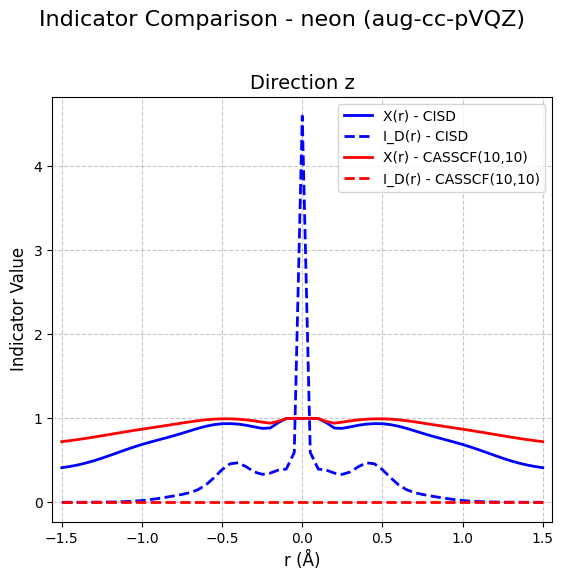

In [6]:
results = run_calculation(
    molecule_name="hexatriene",
    method_name=methods + ['CASSCF(6,6)'],
    basis_name=basis_name,
    scanning_props=scanning_props
)

fig = plot_indicators_comparison(results)


## Excited states

In [ ]:
results = run_calculation(
    molecule_name="ethene",
    method_name=methods + ['CASSCF(2,2)'],
    basis_name=basis_name,
    scanning_props=scanning_props,
    excited_state = 1
)

fig = plot_indicators_comparison(results)